# Integração de Dados Climáticos para o Protótipo NAIÁ

Este notebook integra dados climáticos do Copernicus Climate Data Store (CDS) ao projeto NAIÁ, no contexto do Hackathon CopernicusLAC Panamá 2025 (Dia 1, 23:34, 29/07/2025, -03). O objetivo é:
1. Baixar dados ERA5-Land (precipitação total e temperatura a 2m) para Barão Geraldo, Campinas (SP), na bounding box `[-47.15, -22.75, -46.95, -22.95]`.
2. Agregar métricas climáticas por setor censitário usando `data/area_prova_barao.geojson`.
3. Mesclar com métricas de Sentinel-1 e Sentinel-2 (`data/processed/metrics.csv`) para correlacionar NDVI e backscatter com variáveis climáticas.
4. Gerar gráficos de correlação e salvar resultados em `data/processed/climate_metrics.csv`.

## Configuração
- **Ambiente**: `naia-env` (Python 3.12.7).
- **Repositório**: `/home/lorhan/git/CorpenicusHackthon/`.
- **Entradas**:
  - `data/area_prova_barao.geojson`: Setores censitários.
  - `data/processed/metrics.csv`: Métricas de NDVI e backscatter.
  - Dados ERA5-Land via CDSAPI: `data/processed/data_0.nc` (extraído de um ZIP).
- **Saídas**:
  - `data/processed/climate_metrics.csv`: Métricas climáticas por setor (precipitação média, temperatura média).
  - `data/processed/ndvi_precip_correlation.png`: Gráfico de correlação NDVI vs. precipitação.
  - `data/processed/ndvi_temp_correlation.png`: Gráfico de correlação NDVI vs. temperatura.

## Pré-requisitos
1. Ative o ambiente: `source naia-env/bin/activate`.
2. Instale dependências:
   ```bash
   pip install xarray netCDF4 cdsapi>=0.7.4 geopandas pandas numpy matplotlib scipy
   pip freeze > requirements.txt
   ```
3. Configure a API CDSAPI:
   - Crie `~/.cdsapirc` com suas credenciais do CDS ([cds.climate.copernicus.eu](https://cds.climate.copernicus.eu)):
     ```bash
     echo "url: https://cds.climate.copernicus.eu/api/v2" > ~/.cdsapirc
     echo "key: seu_uid:seu_api_key" >> ~/.cdsapirc
     ```
4. Execute `ingest_sentinel.ipynb`, `preprocess.ipynb`, e `analyze.ipynb` para gerar `data/processed/metrics.csv`.
5. Extraia `data_0.nc` do ZIP baixado pelo CDSAPI e coloque em `data/processed/`.
6. Execute as células sequencialmente.

In [ ]:
# Importações
import os
import cdsapi
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from shapely.geometry import box

# Configurar diretórios
os.makedirs('data/processed', exist_ok=True)
print('✓ Diretório data/processed/ criado ou já existente')

# Verificar versão do cdsapi
import cdsapi
print(f'✓ Versão do cdsapi: {cdsapi.__version__}')

# Definir caminhos
sectors_path = 'data/area_prova_barao.geojson'
metrics_path = 'data/processed/metrics.csv'
climate_path = 'data/processed/data_0.nc'
output_csv = 'data/processed/climate_metrics.csv'

# Verificar arquivos de entrada
print('\n--- Verificando arquivos de entrada ---')
for path in [sectors_path, metrics_path]:
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f'✓ {path} ({size_mb:.1f} MB)')
    else:
        print(f'❌ {path} não encontrado')

## 1. Download de Dados Climáticos

Baixamos dados ERA5-Land (precipitação total e temperatura a 2m) para a bounding box de Barão Geraldo, período de 01/06/2025 a 30/06/2025. A bounding box `[-47.15, -22.75, -46.95, -22.95]` foi validada para conter múltiplos pontos.

In [ ]:
try:
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-land',
        {
            'variable': ['total_precipitation', '2m_temperature'],
            'year': '2025',
            'month': '06',
            'day': [str(i).zfill(2) for i in range(1, 31)],
            'time': ['00:00', '06:00', '12:00', '18:00'],
            'area': [-22.75, -47.15, -22.95, -46.95],  # [N, W, S, E]
            'format': 'netcdf'
        },
        'data/processed/era5_climate.nc')
    print(f'✓ Dados climáticos salvos em data/processed/era5_climate.nc')
except Exception as e:
    print(f'❌ Erro ao baixar dados ERA5-Land: {e}')

## 2. Verificação de Coordenadas

Inspecionamos as coordenadas do NetCDF e dos setores para confirmar cobertura.

In [42]:
try:
    # Verificar NetCDF
    if os.path.exists(climate_path):
        ds = xr.open_dataset(climate_path, engine='netcdf4')
        print(f'✓ Coordenadas do NetCDF:')
        print(f'  Latitude: {ds['latitude'].values}')
        print(f'  Longitude: {ds['longitude'].values}')
        print(f'  Bounding box: (min_lon, min_lat, max_lon, max_lat) = '
              f'({ds['longitude'].min().values}, {ds['latitude'].min().values}, '
              f'{ds['longitude'].max().values}, {ds['latitude'].max().values})')
        print(f'  Número de pontos: {len(ds['latitude']) * len(ds['longitude'])}')

        # Verificar cobertura dos setores
        gdf = gpd.read_file(sectors_path)
        gdf = gdf[(gdf['SITUACAO'] == 'Urbana') & (gdf['AREA_KM2'] <= 1.0)]
        bounds = gdf.bounds
        sectors_bbox = (bounds['minx'].min(), bounds['miny'].min(), bounds['maxx'].max(), bounds['maxy'].max())
        print(f'\n✓ Bounding box dos setores censitários:')
        print(f'  (min_lon, min_lat, max_lon, max_lat) = {sectors_bbox}')
        print(f'\n✓ Verificação de cobertura:')
        if (ds['longitude'].min() <= sectors_bbox[0] and ds['longitude'].max() >= sectors_bbox[2] and
            ds['latitude'].min() <= sectors_bbox[1] and ds['latitude'].max() >= sectors_bbox[3]):
            print('  ✓ NetCDF cobre completamente a área dos setores')
        else:
            print('  ⚠️ NetCDF não cobre completamente a área dos setores')
        ds.close()
    else:
        print(f'❌ {climate_path} não encontrado')

    # Resumo dos setores
    print(f'\n✓ Total de setores urbanos: {len(gdf)}')
except Exception as e:
    print(f'❌ Erro ao verificar coordenadas: {e}')

✓ Coordenadas do NetCDF:
  Latitude: [-22.75 -22.85 -22.95]
  Longitude: [-47.15 -47.05 -46.95]
  Bounding box: (min_lon, min_lat, max_lon, max_lat) = (-47.15, -22.95, -46.95, -22.75)
  Número de pontos: 9

✓ Bounding box dos setores censitários:
  (min_lon, min_lat, max_lon, max_lat) = (-47.11041019999993, -22.864497, -47.050754, -22.76809989999998)

✓ Verificação de cobertura:
  ✓ NetCDF cobre completamente a área dos setores

✓ Total de setores urbanos: 128


## 3. Carregamento e Agregação por Setor

Carregamos os dados climáticos e agregamos métricas (média mensal) por setor censitário, com interpolação como fallback.

In [43]:
def aggregate_climate_by_sector(climate_path, sectors_path):
    """Agrega dados climáticos por setor censitário."""
    try:
        # Verificar arquivo NetCDF
        if not os.path.exists(climate_path):
            raise FileNotFoundError(f'{climate_path} não encontrado')
        with xr.open_dataset(climate_path, engine='netcdf4') as ds:
            print(f'✓ Arquivo {climate_path} válido, variáveis: {list(ds.variables)}')

        # Carregar setores censitários
        gdf = gpd.read_file(sectors_path)
        gdf = gdf[(gdf['SITUACAO'] == 'Urbana') & (gdf['AREA_KM2'] <= 1.0)]
        print(f'✓ Carregados {len(gdf)} setores urbanos')

        # Carregar dados climáticos
        ds = xr.open_dataset(climate_path, engine='netcdf4')
        # Corrigir nomes de variáveis
        ds['total_precipitation'] = ds['tp'] * 1000  # metros para mm
        ds['t2m'] = ds['t2m'] - 273.15  # Kelvin para °C

        # Média mensal por pixel
        precip_mean = ds['total_precipitation'].mean(dim='valid_time')
        temp_mean = ds['t2m'].mean(dim='valid_time')

        # Configurar interpoladores
        lat, lon = ds['latitude'].values, ds['longitude'].values
        precip_interp = RegularGridInterpolator(
            (lat, lon), precip_mean.values,
            method='nearest', bounds_error=False, fill_value=np.nan
        )
        temp_interp = RegularGridInterpolator(
            (lat, lon), temp_mean.values,
            method='nearest', bounds_error=False, fill_value=np.nan
        )

        climate_metrics = []
        sectors_with_data = 0
        for idx, row in gdf.iterrows():
            cd_setor = int(row['CD_SETOR'])  # Converter para int64
            geom = row['geometry']
            bounds = geom.bounds  # (minx, miny, maxx, maxy)
            # Máscara ajustada para latitude decrescente
            mask = (ds['longitude'] >= bounds[0]) & (ds['longitude'] <= bounds[2]) & \
                   (ds['latitude'] >= bounds[3]) & (ds['latitude'] <= bounds[1])
            if mask.any():
                precip = precip_mean.where(mask, drop=True).mean().values
                temp = temp_mean.where(mask, drop=True).mean().values
                if not np.isnan(precip) and not np.isnan(temp):
                    sectors_with_data += 1
                climate_metrics.append({
                    'CD_SETOR': cd_setor,
                    'precip_mean_mm': float(precip) if not np.isnan(precip) else np.nan,
                    'temp_mean_C': float(temp) if not np.isnan(temp) else np.nan
                })
                print(f'✓ Processado setor {cd_setor}: Precip={precip:.2f} mm, Temp={temp:.2f} °C')
            else:
                # Fallback: usar interpolação no centróide do setor
                centroid = geom.centroid
                precip = precip_interp((centroid.y, centroid.x))
                temp = temp_interp((centroid.y, centroid.x))
                if not np.isnan(precip) and not np.isnan(temp):
                    sectors_with_data += 1
                climate_metrics.append({
                    'CD_SETOR': cd_setor,
                    'precip_mean_mm': float(precip) if not np.isnan(precip) else np.nan,
                    'temp_mean_C': float(temp) if not np.isnan(temp) else np.nan
                })
                print(f'⚠️ Setor {cd_setor} fora da grade; usado interpolação: Precip={precip:.2f} mm, Temp={temp:.2f} °C')
        print(f'\n✓ Total de setores com dados válidos: {sectors_with_data}/{len(gdf)}')
        climate_df = pd.DataFrame(climate_metrics)
        climate_df['CD_SETOR'] = climate_df['CD_SETOR'].astype('int64')  # Garantir tipo int64
        return climate_df
    except Exception as e:
        print(f'❌ Erro ao agregar dados climáticos: {e}')
        return None

if os.path.exists(climate_path) and os.path.exists(sectors_path):
    print('\n--- Agregando dados climáticos por setor ---')
    climate_df = aggregate_climate_by_sector(climate_path, sectors_path)
    if climate_df is not None:
        climate_df.to_csv(output_csv, index=False)
        print(f'✓ Métricas climáticas salvas em {output_csv}')
else:
    print('❌ Pulando agregação devido a arquivos ausentes')


--- Agregando dados climáticos por setor ---
✓ Arquivo data/processed/data_0.nc válido, variáveis: ['tp', 't2m', 'number', 'valid_time', 'latitude', 'longitude', 'expver']
✓ Carregados 128 setores urbanos
⚠️ Setor 350950210000001 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000002 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000003 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000005 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000006 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000007 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000017 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000021 fora da grade; usado interpolação: Precip=0.71 mm, Temp=17.69 °C
⚠️ Setor 350950210000024 fora da grade; usado interpolação: Precip=0.71 mm

## 4. Mesclagem e Correlação

Mesclamos os dados climáticos com `metrics.csv` e calculamos correlações.


--- Mesclando e calculando correlações ---
✓ Tipo de CD_SETOR em metrics_df: int64
✓ Tipo de CD_SETOR em climate_df: int64
✓ Dados mesclados salvos em data/processed/climate_metrics.csv

Correlações:
                NDVI_mean  VV_mean_dB  VH_mean_dB  precip_mean_mm  temp_mean_C
NDVI_mean        1.000000   -0.089903   -0.406201        0.254586     0.133290
VV_mean_dB      -0.089903    1.000000    0.596891       -0.121398    -0.300803
VH_mean_dB      -0.406201    0.596891    1.000000       -0.026946    -0.145210
precip_mean_mm   0.254586   -0.121398   -0.026946        1.000000     0.831440
temp_mean_C      0.133290   -0.300803   -0.145210        0.831440     1.000000


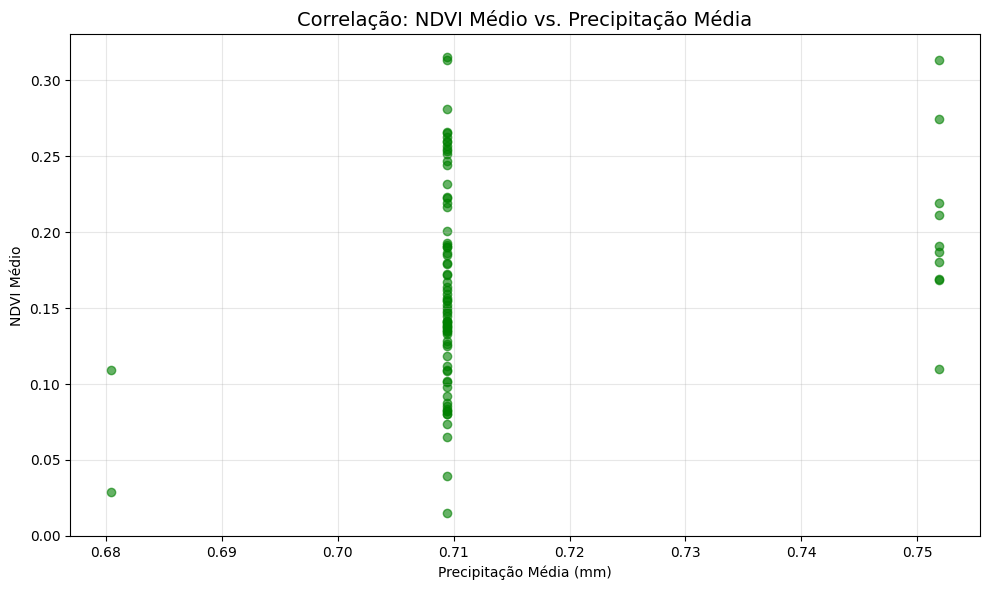

✓ Gráfico salvo em data/processed/ndvi_precip_correlation.png


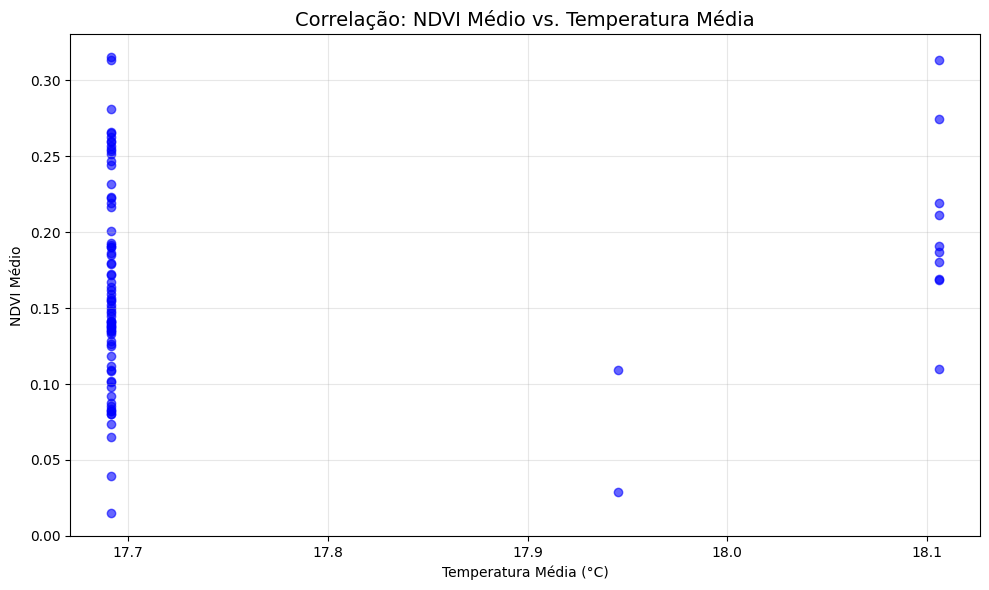

✓ Gráfico salvo em data/processed/ndvi_temp_correlation.png


In [44]:
if 'climate_df' in locals() and os.path.exists(metrics_path):
    print('\n--- Mesclando e calculando correlações ---')
    metrics_df = pd.read_csv(metrics_path)
    # Verificar tipos de dados
    print(f'✓ Tipo de CD_SETOR em metrics_df: {metrics_df['CD_SETOR'].dtype}')
    print(f'✓ Tipo de CD_SETOR em climate_df: {climate_df['CD_SETOR'].dtype}')
    # Garantir que CD_SETOR em metrics_df seja int64
    metrics_df['CD_SETOR'] = metrics_df['CD_SETOR'].astype('int64')
    merged_df = metrics_df.merge(climate_df, on='CD_SETOR', how='left')
    merged_df.to_csv(output_csv, index=False)
    print(f'✓ Dados mesclados salvos em {output_csv}')

    # Calcular correlações
    correlations = merged_df[['NDVI_mean', 'VV_mean_dB', 'VH_mean_dB', 'precip_mean_mm', 'temp_mean_C']].corr()
    print('\nCorrelações:')
    print(correlations)

    # Gráfico: NDVI vs. Precipitação
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['precip_mean_mm'], merged_df['NDVI_mean'], color='green', alpha=0.6)
    plt.title('Correlação: NDVI Médio vs. Precipitação Média', fontsize=14)
    plt.xlabel('Precipitação Média (mm)')
    plt.ylabel('NDVI Médio')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/ndvi_precip_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Gráfico salvo em data/processed/ndvi_precip_correlation.png')

    # Gráfico: NDVI vs. Temperatura
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['temp_mean_C'], merged_df['NDVI_mean'], color='blue', alpha=0.6)
    plt.title('Correlação: NDVI Médio vs. Temperatura Média', fontsize=14)
    plt.xlabel('Temperatura Média (°C)')
    plt.ylabel('NDVI Médio')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('data/processed/ndvi_temp_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('✓ Gráfico salvo em data/processed/ndvi_temp_correlation.png')
else:
    print('❌ Pulando mesclagem devido a dados ausentes')

## 5. Resumo da Execução

Resumimos o status da integração climática.

In [ ]:
print('\n' + '='*50)
print('📋 RESUMO DA EXECUÇÃO')
print('='*50)
if 'climate_df' in locals():
    print(f'✓ Setores com métricas climáticas: {len(climate_df)}')
    print(f'✓ Setores com dados válidos: {len(climate_df[climate_df[["precip_mean_mm", "temp_mean_C"]].notna().all(axis=1)])}')
    print(f'✓ Média Precipitação: {climate_df["precip_mean_mm"].mean():.2f} mm')
    print(f'✓ Média Temperatura: {climate_df["temp_mean_C"].mean():.2f} °C')
if 'merged_df' in locals():
    print(f'✓ Correlação NDVI-Precipitação: {correlations.loc["NDVI_mean", "precip_mean_mm"]:.3f}')
    print(f'✓ Correlação NDVI-Temperatura: {correlations.loc["NDVI_mean", "temp_mean_C"]:.3f}')

print('\n🗂️ ARQUIVOS GERADOS:')
import glob
for file in glob.glob('data/processed/*climate*.csv') + glob.glob('data/processed/*correlation*.png'):
    if os.path.exists(file):
        print(f'  ✓ {file} (Tamanho: {os.path.getsize(file) / 1024 / 1024:.2f} MB)')

## 6. Validação e Instruções

- **Validação**:
  - Abra `data/processed/climate_metrics.csv` para verificar as métricas:
    ```bash
    head data/processed/climate_metrics.csv
    ```
  - Inspecione os gráficos:
    ```bash
    xdg-open data/processed/ndvi_precip_correlation.png
    xdg-open data/processed/ndvi_temp_correlation.png
    ```
  - Verifique coordenadas do NetCDF:
    ```python
    import xarray as xr
    ds = xr.open_dataset('data/processed/data_0.nc', engine='netcdf4')
    print(f'Latitude: {ds['latitude'].values}')
    print(f'Longitude: {ds['longitude'].values}')
    print(f'Num pontos: {len(ds['latitude']) * len(ds['longitude'])}')
    ```
- **Solução de Problemas**:
  - Se alguns setores tiverem `NaN`, verifique os valores interpolados:
    ```python
    import pandas as pd
    df = pd.read_csv('data/processed/climate_metrics.csv')
    print(df[df[['precip_mean_mm', 'temp_mean_C']].isna().any(axis=1)])
    ```
  - Se necessário, reexecute o download com uma bounding box maior (edite célula 1):
    ```python
    'area': [-22.70, -47.20, -23.00, -46.90]  # Margem maior
    ```
    E reexecute:
    ```bash
    rm data/processed/data_0.nc
    jupyter notebook climate.ipynb
    ```
  - Extraia `data_0.nc` do ZIP gerado e atualize `climate_path` se necessário.
- **Commit**:
   ```bash
   git add climate.ipynb data/processed/climate_metrics.csv data/processed/*correlation*.png
   git commit -m "Integração: corrigido tipo de CD_SETOR para merge"
   git push origin main
   ```